# Fundamentals of Data Visualization
## Using geospatial Data 

sources:
* https://towardsdatascience.com/how-tracking-apps-analyse-your-gps-data-a-hands-on-tutorial-in-python-756d4db6715d

In [21]:
import pandas as pd
import gpxpy
import matplotlib.pyplot as plt


In [3]:
# importing and parsing the gpx file 
gpx_file = open('data/Lunch_Run.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

In [13]:
# check how the data is devided
len(gpx.tracks)
len(gpx.tracks[0].segments)
len(gpx.tracks[0].segments[0].points)

# everything is in points
data = gpx.tracks[0].segments[0].points

In [80]:
# add all information to a dataframe
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])

for point in data:
    df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time.strftime('%H:%M:%S')}, ignore_index=True)

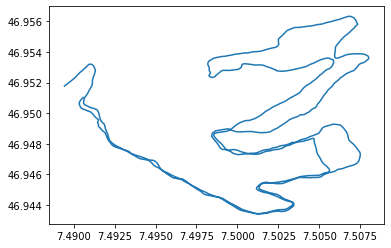

In [71]:
# simple lon/lat plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df['lon'],df['lat'])

fig.savefig('1.png')


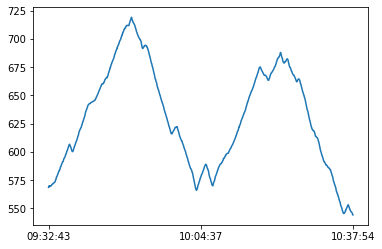

In [90]:
# elevation vs. time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df['time'],df['alt'])
ax.set_xticks([0,len(df['time'])/2,len(df['time'])-1])

fig.savefig('2.png')

In [88]:
len(df['time'])/2

557.0